In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [2]:
train_data = pd.read_csv(r"./data/train.csv")
print(train_data.info())
train_data.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
249,250,0,2,"Carter, Rev. Ernest Courtenay",male,54.0,1,0,244252,26.0000,NaN,S
208,209,1,3,"Carr, Miss. Helen ""Ellen""",female,16.0,0,0,367231,7.7500,NaN,Q
727,728,1,3,"Mannion, Miss. Margareth",female,NaN,0,0,36866,7.7375,NaN,Q


In [3]:
def visualize_data(data):
    data = data.drop(['PassengerId'], axis=1)
    sns.countplot(x="Embarked", hue="Survived", data=data)
    plt.legend(['Died', 'Survived'])
    plt.show()

    sns.heatmap(data.corr(), annot=True, square=True, cmap='coolwarm')
    

In [4]:
def preprocess_data(subset):
    mean_imp = SimpleImputer(strategy='mean')
    
    age = np.array(subset["Age"]).reshape(-1, 1)
    age = mean_imp.fit_transform(age)

    Pclass = np.array(subset["Pclass"]).reshape(-1,1)

    sex = np.array(subset["Sex"]).reshape(-1,1)
    sex = (sex != "male").astype(int)

    SibSp = np.array(subset["SibSp"]).reshape(-1,1)
    
    embarked = np.array(subset["Embarked"])
    embarked = LabelEncoder().fit_transform(embarked).reshape(-1,1)

    features = np.concatenate((age, Pclass, sex, SibSp, embarked), axis=1)
    return features

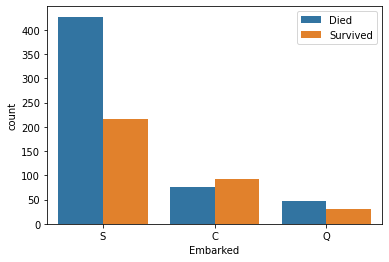

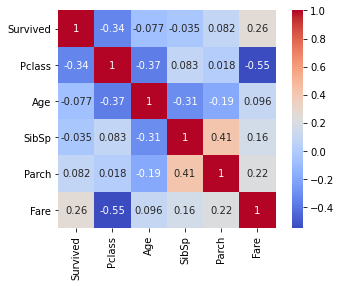

In [5]:
subset = train_data[["Survived", "Age", "Pclass", "Sex", "SibSp", "Embarked", "Fare"]]
visualize_data(train_data)
y = np.array(subset["Survived"])


features = preprocess_data(subset)

In [6]:
test_data = pd.read_csv(r"./data/test.csv")

test_subset = test_data[["Age", "Pclass", "Sex", "SibSp", "Embarked", "Fare"]]

test_features = preprocess_data(test_subset)

In [12]:
X = features
skf = StratifiedKFold(n_splits=5)
best_classifier = None
best_score = 0
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = RandomForestClassifier(max_depth=4).fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    if score > best_score:
        best_score = score
        best_classifier = clf
    print(f"Score: {score}")
    

[[22.  3.  0.  1.  2.]
 [38.  1.  1.  1.  0.]
 [26.  3.  1.  0.  2.]
 [35.  1.  1.  1.  2.]
 [35.  3.  0.  0.  2.]]
[0 1 1 1 0]
Score: 0.8268156424581006
Score: 0.8258426966292135
Score: 0.8202247191011236
Score: 0.797752808988764
Score: 0.8539325842696629


In [8]:
overall_score = best_classifier.score(X, y)
predictions = best_classifier.predict(test_features).reshape(-1,1)
print(f"Score on training data: {overall_score}")
print(f"Number of predictions on test data: {len(predictions)}")

Score on training data: 0.8372615039281706
Number of predictions on test data: 418


In [9]:
pids = np.array(test_data["PassengerId"]).reshape(-1,1)
submission = np.concatenate((pids, predictions), axis=1)
submission = pd.DataFrame(submission, columns=['PassengerId', 'Survived'])
submission.to_csv('submission.csv',index=False)